# Water Quality Data

This notebook contains the code used to pull together raw exported CMC and CBP water quality data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## CMC Water Quality

In [2]:
# reading in CMC water data for each state: Jan 1, 1990 - July 11, 2020
water_dc = pd.read_csv('./Data/CMC_water/water_DC.csv', low_memory = False)
water_de = pd.read_csv('./Data/CMC_water/water_DE.csv', low_memory = False)
water_md = pd.read_csv('./Data/CMC_water/water_MD.csv', low_memory = False)
water_ny = pd.read_csv('./Data/CMC_water/water_NY.csv', low_memory = False)
water_pa = pd.read_csv('./Data/CMC_water/water_PA.csv', low_memory = False)
water_va = pd.read_csv('./Data/CMC_water/water_VA.csv', low_memory = False)
water_wv = pd.read_csv('./Data/CMC_water/water_WV.csv', low_memory = False)

In [3]:
# adding new column to track state
water_dc['state'] = 'DC'
water_de['state'] = 'DE'
water_md['state'] = 'MD'
water_ny['state'] = 'NY'
water_pa['state'] = 'PA'
water_va['state'] = 'VA'
water_wv['state'] = 'WV'

In [4]:
# check shapes
print("DC: ", water_dc.shape)
print("DE: ", water_de.shape)
print("MD: ", water_md.shape)
print("NY: ", water_ny.shape)
print("PA: ", water_pa.shape)
print("VA: ", water_va.shape)
print("WV: ", water_wv.shape)

DC:  (1390, 205)
DE:  (1336, 163)
MD:  (14738, 499)
NY:  (7144, 181)
PA:  (16718, 307)
VA:  (17792, 433)
WV:  (102, 109)


In [5]:
# calculating total expected rows
total = water_dc.shape[0] + \
        water_de.shape[0] + \
        water_md.shape[0] + \
        water_ny.shape[0] + \
        water_pa.shape[0] + \
        water_va.shape[0] + \
        water_wv.shape[0]
print(total)

59220


In [6]:
# combine into one
water = pd.concat([water_dc, water_de, water_md, water_ny, water_pa, water_va, water_wv], axis = 0, sort = True)
print("CMC water (all states): ", water.shape) # checking shape of combined df
print("CMC water (without duplicates): ", water.drop_duplicates().shape)

CMC water (all states):  (59220, 715)
CMC water (without duplicates):  (59220, 715)


Do not appear to be duplicate rows in the dataset.

#### Dropping Unnecessary Columns

In [7]:
# DROP CODES - from CMC, codes not to be used
cmc_drop = ['AT.7', 'AT.8', 'DO.13', 'ECOLI.3', 'FC.1', 'PH.14', 'SA.5', 'WC.11', 'WT.11']
# get columns
columns = water.columns
drop = []
for x in cmc_drop:
    droplist = [i for i in columns if x in i]
    drop.extend(droplist)

In [8]:
water = water.drop(columns = drop)

In [9]:
water.shape

(59220, 667)

### Pivoting to Match CBP

In [10]:
water.columns = [i.replace('(E.Coli)', '[E.Coli]') for i in water.columns] # so we can split on parens

params = [i for i in water.columns if '(' in i] # get just parameter columns
other  = [i for i in water.columns if i not in params] # get other non parameter columns

# get unique parameter codes
codes = list(set([i.split('(')[1].split(')')[0] for i in params]))
codes = ['(' + i + ')' for i in codes] # adding parens back

In [11]:
commoncols = ['Measure', 'Code', 'Problem', 'Qualifier', 'Tier', 'Units', 'Parameter'] # each param has these cols
cmc_water = pd.DataFrame()
count = 0
for x in codes:
    this_param = [i for i in params if x in i] # get just the column names for this param
    paramname = this_param[0].split('(')[0] # get the name of the parameter
    measure = this_param[0]
    
    assert len(this_param)==6 # make sure just 6 columns per parameter
    
    # dictionary to map new column names
    newcols = {this_param[0]: "MeasureValue",
               this_param[1]: "Parameter",
               this_param[2]: "Problem",
               this_param[3]: "Qualifier",
               this_param[4]: "TierLevel",
               this_param[5]: "Unit"
              }
    
    mycols = other + this_param # get full list of columns to subset
    mydf = water[mycols] # subset to df
    mydf = mydf[mydf[measure].notna()] # drop if measure column is null
    
    mydf.rename(columns = newcols, inplace = True) # renaming to generic columns
    mydf['ParameterName_CMC'] = paramname
    
    cmc_water = pd.concat([cmc_water, mydf], axis = 0, sort = True)
    print("{} rows added for {}".format(mydf.shape[0], x))
    count += mydf.shape[0]
print("Total rows: ", count)

137 rows added for (CHL.3)
3050 rows added for (DO.6)
792 rows added for (NO3N.5)
1549 rows added for (SA.9)
4602 rows added for (DO.5)
2575 rows added for (NO3N.6)
1867 rows added for (WC.2)
723 rows added for (WT.8)
65 rows added for (PH.6)
2978 rows added for (CO.8)
1808 rows added for (AT.3)
1309 rows added for (OP.1)
4299 rows added for (WT.1)
292 rows added for (NH4N.1)
4616 rows added for (WT.4)
125 rows added for (AT.11)
4072 rows added for (AT.2)
3326 rows added for (CHL.1)
2613 rows added for (ECOLI.4)
203 rows added for (TP.3)
3706 rows added for (NO3N.1)
642 rows added for (ECOLI.6)
150 rows added for (CO.9)
90 rows added for (WC.7)
3126 rows added for (OP.3)
3454 rows added for (ECOLI.1)
10156 rows added for (TDS.1)
355 rows added for (WT.5)
3198 rows added for (WC.5)
4421 rows added for (WC.6)
2258 rows added for (AT.1)
1794 rows added for (AT.10)
589 rows added for (NO3N.2)
144 rows added for (TDS.3)
776 rows added for (AT.9)
1373 rows added for (ENT.2)
8763 rows added f

In [12]:
# set database to CMC to track source
cmc_water['Database'] = 'CMC'

In [13]:
cmc_water.shape

(264261, 39)

## CBP Water Quality

In [14]:
cbp1 = pd.read_csv('./Data/CBP_water/CBP_WaterQualityHUC12_2005-2010.csv', low_memory = False)
cbp2 = pd.read_csv('./Data/CBP_water/CBP_WaterQualityHUC12_2010-2015.csv', low_memory = False)
cbp3 = pd.read_csv('./Data/CBP_water/CBP_WaterQualityHUC12_2015-2020.csv', low_memory = False)

In [15]:
# checking shape of each csv
print(cbp1.shape)
print(cbp2.shape)
print(cbp3.shape)

(1895654, 30)
(1631328, 30)
(1370283, 30)


In [16]:
# calculating total expected rows
total = cbp1.shape[0] + \
        cbp2.shape[0] + \
        cbp3.shape[0]
print(total)

4897265


In [17]:
# combine into one
cbp_water = pd.concat([cbp1, cbp2, cbp3], axis = 0, sort = True)
print("all: ", cbp_water.shape) # checking shape of combined df

all:  (4897265, 30)


In [18]:
cbp_water.head()

,Agency,BiasPC,Cruise,Depth,Details,EventId,HUC12,Lab,Latitude,Layer,Longitude,LowerPycnocline,MeasureValue,Method,Parameter,PrecisionPC,Problem,Program,Project,Qualifier,SampleDate,SampleReplicateType,SampleTime,SampleType,Source,Station,TierLevel,TotalDepth,Unit,UpperPycnocline
0,MDDNR,NaN,BAY509,0.5,NaN,106165.0,020403030303,MDHMH,38.44902,BS,-75.13245,NaN,132.737,L01,CHLA,NaN,NaN,SWM,CMON,NaN,7/22/2009,S1,11:30:00,D,MDDNR,XDN6921,T3,0.8,UG/L,NaN
1,MDDNR,NaN,BAY531,0.1,NaN,112549.0,020403030303,MDHMH,38.44902,BS,-75.13245,NaN,100.392,L01,CHLA,NaN,NaN,SWM,CMON,NaN,6/22/2010,S1,11:45:00,D,MDDNR,XDN6921,T3,0.4,UG/L,NaN
2,MDDNR,NaN,BAY532,0.1,NaN,112810.0,020403030303,MDHMH,38.44902,BS,-75.13245,NaN,51.264,L01,CHLA,NaN,NaN,SWM,CMON,NaN,7/7/2010,S1,11:30:00,D,MDDNR,XDN6921,T3,0.4,UG/L,NaN
3,MDDNR,NaN,BAY492,0.4,NaN,81372.0,020403030303,MDHMH,38.44902,BS,-75.13245,NaN,22.802,L01,CHLA,NaN,NaN,SWM,CMON,NaN,11/12/2008,S1,10:00:00,D,MDDNR,XDN6921,T3,0.7,UG/L,NaN
4,MDDNR,NaN,BAY514,0.5,NaN,93090.0,020403030303,MDHMH,38.44902,BS,-75.13245,NaN,32.040,L01,CHLA,NaN,NaN,SWM,CMON,NaN,10/15/2009,S1,11:45:00,D,MDDNR,XDN6921,T3,0.8,UG/L,NaN


#### Read in Monitoring Event Data

In [19]:
events = pd.read_csv('./Data/CBP_water/CBP_2005-2020_waterevents.csv', low_memory='False')

# filter to just columns not already in CBP
newcols = [i for i in events.columns if i not in cbp_water.columns]
newcols.append("EventId")
events = events[newcols] 

# merge cbp water with event data
cbp_water = cbp_water.merge(events, on = 'EventId')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
cbp_water.shape

(4897265, 41)

#### Map Parameter Name

In [21]:
# read in cbp water dict
names = pd.read_csv('./Data/CBP_water_dictionary.csv')

namesdict = dict(zip(names["CBP Code"], names["CBP Parameter"])) # dict for names

cbp_water['ParameterName_CBP'] = cbp_water['Parameter'].map(namesdict) # map

In [22]:
cbp_water['ParameterName_CBP'].isnull().sum()

467578

In [23]:
# some weren't in the dictionary, but none of these are in the final parameters we want anyway
cbp_water[cbp_water['ParameterName_CBP'].isnull()]['Parameter'].unique()

array(['SPCOND', 'SSC_TOTAL', 'SSC_FINE', 'SSC_SAND', 'FCOLI_C',
       'SSC_%FINE', 'FCOLI_M', 'CDOM_440', 'CDOM_SLOPE', 'TCOLI_M',
       'DO_SAT_P', nan, 'SSC_%SAND', 'TURB_FNU', 'POC', 'TURB_NTRU'],
      dtype=object)

#### Filter to Parameters in CMC database

In [24]:
# filter to just the parameters in CMC database
common = ['AIR TEMPERATURE DEG',
          'ACTIVE CHLOROPHYLL-A',
          'CONDUCTIVITY CORRECTED FOR TEMPERATURE (25 DEG C) AND SALINITY',
          'DISSOLVED OXYGEN IN MG/L',
          'DO SATURATION USING PROBE UNITS IN PERCENT',
          'AMMONIUM NITROGEN AS N (FILTERED SAMPLE)',
          'NITRATE NITROGEN AS N (FILTERED SAMPLE)',
          'PH CORRECTED FOR TEMPERATURE (25 DEG C)',
          'ORTHOPHOSPHATE PHOSPHORUS AS P (FILTERED SAMPLE)',
          'SALINITY UNITS IN PPT AND EQUAL TO PRACTICAL SALNITY UNITS (PSU)',
          'SECCHI DEPTH',
          'TOTAL ALKALINITY AS CACO3',
          'TOTAL DISSOLVED SOLIDS; GRAVIMETRIC; DRIED AT 180 C',
          'TOTAL KJELDAHL NITROGEN (WHOLE SAMPLE)',
          'TOTAL NITROGEN',
          'TOTAL PHOSPHORUS',
          'TOTAL SUSPENDED SOLIDS',
          'TURBIDITY; JACKSON CANDLE METHOD (FORWARD SCATTER)',
          'TURBIDITY; NEPHELOMETRIC METHOD',
          'TURBIDITY TUBE',
          'WATER TEMPERATURE DEG',
          'SPECIFIC CONDUCTIVITY',
          'E.COLI BACTERIA',
          'TOTAL DEPTH']

In [25]:
# filter to just parameters in CMC database
cbp_water = cbp_water[cbp_water['ParameterName_CBP'].isin(common)]

In [26]:
# adding database source for CBP
cbp_water['Database'] = 'CBP'

### Standardizing CMC, CBP Columns

In [27]:
mymap = pd.read_csv('./Data/CBP_water_dictionary_final.csv')

In [28]:
newmap = pd.DataFrame(mymap['CMC Codes'].str.split(',').tolist(), index=mymap['CBP Parameter']).stack()
newmap = newmap.reset_index([0, 'CBP Parameter'])
newmap[0] = [i.strip().lstrip() for i in newmap[0]]

In [29]:
newmap = dict(zip(newmap[0], newmap['CBP Parameter']))

In [30]:
cmc_water['ParameterName_CBP'] = cmc_water['Parameter'].map(newmap)

In [31]:
cmc_water['ParameterName_CBP'].isnull().sum()

30326

In [32]:
cmc_water[cmc_water['ParameterName_CBP'].isnull()]['Parameter'].unique()

array(['NO3N.5', 'OP.1', 'CHL.1', 'NO3N.1', 'ECOLI.6', 'ECOLI.1', 'TDS.3',
       'ENT.2', 'NO3N.4', 'SA.2', 'WC.12', 'PH.8', 'NO2NO3.1', 'OP.7',
       'OP.4', 'SA.1', 'ENT.1', 'PH.5', 'NO2NO3.4', 'PH.4', 'ECOLI.2'],
      dtype=object)

In [33]:
cmc_water['ParameterName_CBP'].fillna('Not in CBP Database', inplace = True)

In [34]:
# rename CBP columns to match CMC
cbp_water.rename(columns = {'SampleDate': 'Date',
                           'SampleTime': 'Time',
                           'Depth': 'SampleDepth',
                           'EventId': 'SampleId',
                         'Details': 'Comments'}, inplace = True)

# rename CMC columns to match CBP
cmc_water.rename(columns = {'Cloud Cover': 'CloudCover',
                       'Wind Direction': 'WindDirection',
                       'Wind Speed': 'WindSpeed'}, inplace = True)

same = [i for i in cbp_water.columns if i in cmc_water.columns]
cbp_only = [i for i in cbp_water.columns if i not in same]
cmc_only = [i for i in cmc_water.columns if i not in same]

In [35]:
same

['SampleDepth',
 'Comments',
 'SampleId',
 'Latitude',
 'Longitude',
 'MeasureValue',
 'Parameter',
 'Problem',
 'Qualifier',
 'Date',
 'Time',
 'TierLevel',
 'Unit',
 'WindSpeed',
 'WindDirection',
 'CloudCover',
 'ParameterName_CBP',
 'Database']

## Join CMC and CBP

In [36]:
water = pd.concat([cmc_water, cbp_water], axis = 0, sort = True)
water.shape

(2720510, 65)

In [37]:
water = water.dropna(subset = ['MeasureValue']) # drop nulls in measure col

In [38]:
water.to_csv('./Data/Water_FINAL.csv')

## Checking

In [39]:
water.isnull().sum()

Agency                                      264261
BiasPC                                     2708662
CloudCover                                  476847
Comments                                   2613416
Cruise                                      264261
Database                                         0
Date                                             0
FieldActivityEventType                     2512269
FieldActivityRemark                        2708717
FlowStage                                  2702786
GaugeHeight                                2608944
GroupCode                                  2444456
HUC12                                       264261
Lab                                        1843644
Latitude                                         0
Layer                                       264812
Longitude                                        0
LowerPycnocline                            2284282
MeasureValue                                     0
Method                         

In [40]:
water_cmc = water[water['Database']=='CMC']
water_cbp = water[water['Database']=='CBP']

In [41]:
cmc_counts = water_cmc['ParameterName_CBP'].value_counts().to_dict()
cmc_countsdf = pd.DataFrame(cmc_counts.values(), index = cmc_counts.keys())
cmc_countsdf.rename(columns = {0: 'CMC'}, inplace = True)

In [42]:
cbp_counts = water_cbp['ParameterName_CBP'].value_counts().to_dict()
cbp_countsdf = pd.DataFrame(cbp_counts.values(), index = cbp_counts.keys())
cbp_countsdf.rename(columns = {0: 'CBP'}, inplace = True)

In [43]:
counts = pd.concat([cmc_countsdf, cbp_countsdf], axis = 1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [44]:
counts.to_csv('./Data/Water_Summary.csv')

In [45]:
water[['Longitude', 'Latitude']].drop_duplicates().shape

(2544, 2)

In [46]:
water_cmc[['Longitude', 'Latitude']].drop_duplicates().shape

(1657, 2)

In [47]:
water_cbp[['Longitude', 'Latitude']].drop_duplicates().shape

(887, 2)

## EDA

In [48]:
# change to datetime
water_cmc['Real_Date'] = pd.to_datetime(water_cmc['Date'])

# aggregate dates by month/year
water_cmc['month_year'] = water_cmc['Real_Date'].dt.to_period('M')

# sort by month/year
water_cmc = water_cmc.sort_values(by = 'month_year')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


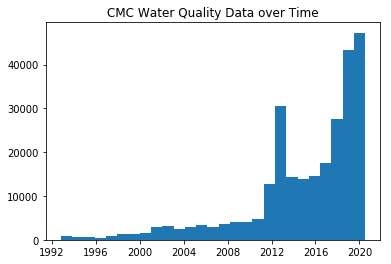

In [49]:
# plot
plt.hist(water_cmc['Real_Date'], bins = 27)
plt.title("CMC Water Quality Data over Time");

In [50]:
# change to datetime
water_cbp['Real_Date'] = pd.to_datetime(water_cbp['Date'])

# aggregate dates by month/year
water_cbp['month_year'] = water_cbp['Real_Date'].dt.to_period('M')

# sort by month/year
water_cbp = water_cbp.sort_values(by = 'month_year')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


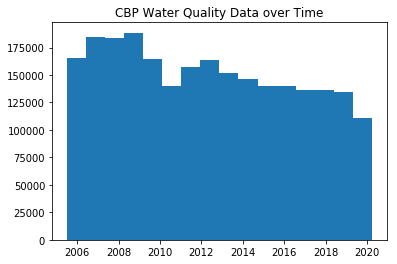

In [53]:
# plot
plt.hist(water_cbp['Real_Date'], bins = 16)
plt.title("CBP Water Quality Data over Time");